<a href="https://colab.research.google.com/github/ww-Jing/Algorithmic_Trading/blob/main/LSTM_gold_price_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras
!pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2955 sha256=b2a8d92cb6a5b491cc2bc825c5d8e3df42173b3ac4cf5e812d2f0c21bd7ecfe2
  Stored in directory: /root/.cache/pip/wheels/f8/e0/3d/9d0c2020c44a519b9f02ab4fa6d2a4a996c98d79ab2f569fa1
Successfully built sklearn


In [4]:
import numpy as np
import math
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import pandas as pd
from matplotlib import pyplot as plt

In [5]:
#目標網站
url="https://rate.bot.com.tw/gold/chart/year/TWD"
#開始爬取該網站
df= pd.read_html(url)

In [6]:
df_gold = df[0]
df_gold=df_gold[["日期","本行賣出價格"]]
df_gold.head()

,日期,本行賣出價格
0,2023/04/07,1974
1,2023/04/06,1986
2,2023/03/31,1952
3,2023/03/30,1937
4,2023/03/29,1930


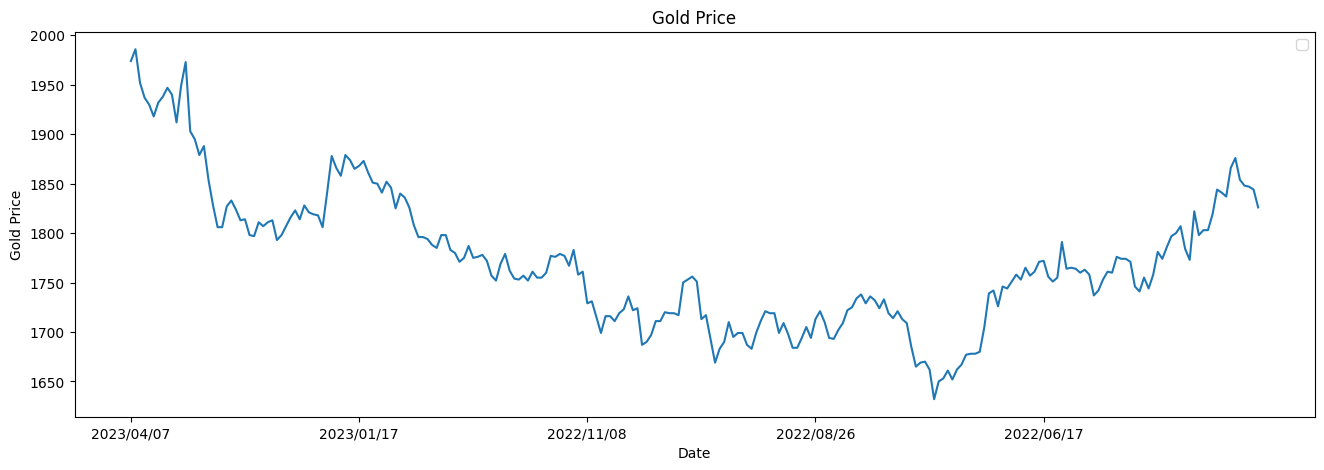

In [7]:
plt.figure(figsize=(16,5), dpi = 100)
Date = df_gold["日期"]
Close = df_gold["本行賣出價格"]

plt.plot(Date, Close)
plt.xticks(np.arange(0, len(Date), step=50))


plt.legend()  # 让图例生效
plt.title('Gold Price')
plt.xlabel('Date') #X轴标签
plt.ylabel("Gold Price") #Y轴标签
plt.xticks(np.arange(0, len(Close), step=50))

plt.show()

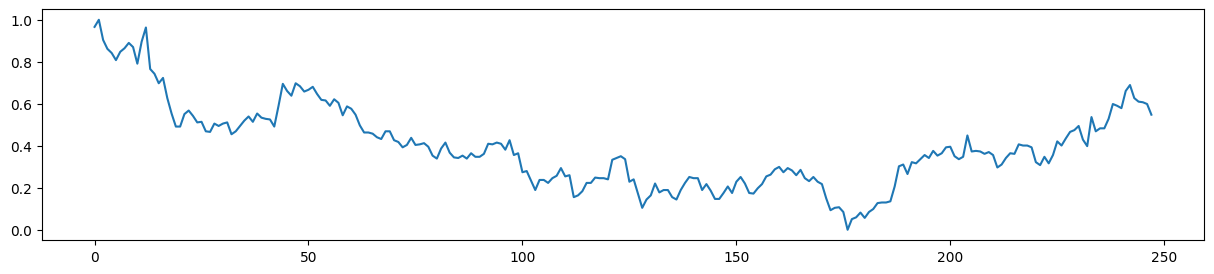

In [8]:
Gold_close = df_gold.filter(["本行賣出價格"]).values

scaler = MinMaxScaler(feature_range=(0,1))
Gold_close_scaler = scaler.fit_transform(Gold_close)
#scaled_data = scaler.fit_transform(data_set)
plt.figure(figsize = (15,3))
plt.plot(Gold_close_scaler)
plt.show()

In [9]:
def data_split(data_set, spilt_ratio):
  train_len = int(len(data_set)* spilt_ratio)
  test_len = len(data_set) - train_len

  train_data = data_set[0:train_len, :]
  test_data = data_set[train_len:len(data_set),:]
  return train_data, test_data

def to_seq(data_set, seq_len):
  x = []
  y = []

  for i in range(len(data_set)-seq_len-1):
    x.append(data_set[i:(i + seq_len), 0 ])
    y.append(data_set[i+seq_len, 0])
  return np.array(x), np.array(y)

In [10]:
train_data, test_data = data_split(Gold_close_scaler, 0.8)
seq_len = 5
x_train, y_train = to_seq(train_data, seq_len)
x_test, y_test = to_seq(test_data, seq_len)

print("shape of train_data: {}".format(x_train.shape))
print("shape of test_data: {}".format(x_test.shape))

shape of train_data: (192, 5)
shape of test_data: (44, 5)


In [13]:
#Reshape input to be [samples, time steps, features]
x_train = x_train.reshape(x_train.shape[0], 1, seq_len )
x_test = x_test.reshape(x_test.shape[0], 1, seq_len)

x_train.shape, x_test.shape

model = Sequential()
model.add(LSTM(64, input_shape=(None, seq_len)))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()


model.fit(x_train, y_train, validation_data = (x_test, y_test), verbose = 0, epochs = 50)

predict_train = model.predict(x_train)
predict_test =  model.predict(x_test)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                17920     
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 20,033
Trainable params: 20,033
Non-trainable params: 0
_________________________________________________________________
2/2 [==============================] - 0s 6ms/step


In [14]:
print(predict_train.shape)
print(predict_test.shape)

(192, 1)
(44, 1)


In [15]:
predict_train = scaler.inverse_transform(predict_train)
y_train = scaler.inverse_transform([y_train])
predict_test =  scaler.inverse_transform(predict_test)
y_test = scaler.inverse_transform([y_test])

In [16]:
train_score = math.sqrt(mean_squared_error(y_train[0], predict_train[:,0]))
print("train_score_RMSE = {:.4f}".format(train_score))
test_score = math.sqrt(mean_squared_error(y_test[0], predict_test[:,0]))
print("test_score_RMSE = {:.4f}".format(test_score))

train_score_RMSE = 16.5284
test_score_RMSE = 18.6575
